Introduction

This notebook performs EDA, time-series forecasting of titles added, content embeddings for recommendations, and UMAP+HDBSCAN clustering for the Netflix `netflix_titles.csv` dataset. Run cell-by-cell in Google Colab.

Install require packages

In [ ]:
# Install required packages (may take ~1-2 minutes)
!pip install -q sentence-transformers umap-learn hdbscan prophet plotly>=5.7.0
!pip install -q scikit-learn pandas matplotlib seaborn
print('Installs completed (if any were missing).')

Installs completed (if any were missing).


In [ ]:
!pip install numpy==1.24.3 plotly==5.15.0 --quiet

IMPORTS AND SETTINGS

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from prophet import Prophet

sns.set_style('whitegrid')
print('Libraries loaded')

Libraries loaded


## 3. Load dataset

In [ ]:
DATA_PATH = "/content/netflix_titles.csv"
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    print('Loaded:', DATA_PATH)
else:
    raise FileNotFoundError("Please upload '/content/netflix_titles.csv' to /content or change DATA_PATH.")

df.head(3)

Loaded: /content/netflix_titles.csv


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


In [ ]:
# to check the dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   show_id             8807 non-null   object        
 1   type                8807 non-null   object        
 2   title               8807 non-null   object        
 3   director            6173 non-null   object        
 4   cast                7982 non-null   object        
 5   country             8807 non-null   object        
 6   date_added          8709 non-null   datetime64[ns]
 7   release_year        8807 non-null   int64         
 8   rating              8803 non-null   object        
 9   duration            8804 non-null   object        
 10  listed_in           8807 non-null   object        
 11  description         8807 non-null   object        
 12  genres_list         8807 non-null   object        
 13  country_list        8807 non-null   object      

## 4. Basic cleaning & feature creation


In [ ]:
df.isnull().sum().sort_values(ascending=False)

,0
director,2634
cast,825
date_added,98
rating,4
duration,3
type,0
title,0
show_id,0
release_year,0
country,0


In [ ]:
df = df.copy()
df.columns = [c.strip() for c in df.columns]
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
df['listed_in'] = df['listed_in'].fillna('')
df['genres_list'] = df['listed_in'].apply(lambda s: [g.strip() for g in s.split(',')] if s else [])
df['country'] = df['country'].fillna('Unknown')
df['country_list'] = df['country'].apply(lambda s: [c.strip() for c in s.split(',')] if pd.notna(s) else ['Unknown'])
print('Rows:', len(df))
df.info()

Rows: 8807
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8807 non-null   object        
 1   type          8807 non-null   object        
 2   title         8807 non-null   object        
 3   director      6173 non-null   object        
 4   cast          7982 non-null   object        
 5   country       8807 non-null   object        
 6   date_added    8709 non-null   datetime64[ns]
 7   release_year  8807 non-null   int64         
 8   rating        8803 non-null   object        
 9   duration      8804 non-null   object        
 10  listed_in     8807 non-null   object        
 11  description   8807 non-null   object        
 12  genres_list   8807 non-null   object        
 13  country_list  8807 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(12)
memory usage: 963.4+ KB


In [ ]:
# Drop rows with missing values in key fields
df_clean = df.dropna(subset=['rating', 'date_added'])

# Fill other less-critical columns (optional)
df_clean.loc[:, 'country'] = df_clean['country'].fillna('Unknown')

## 5. EDA — Top Genres

In [ ]:
import plotly.graph_objs as go

genres = pd.Series([g for sub in df['genres_list'] for g in sub])
top_genres = genres.value_counts().head(20)

fig = go.Figure(data=[go.Bar(x=top_genres.index, y=top_genres.values)])
fig.update_layout(title='Top Genres in Netflix Dataset', xaxis_title='Genre', yaxis_title='Count')
fig.show()

## 6. EDA — Top Countries

In [ ]:
import plotly.graph_objs as go

countries = pd.Series([c for sub in df['country_list'] for c in sub])
top_countries = countries.value_counts().head(20)

fig = go.Figure(data=[go.Bar(x=top_countries.index, y=top_countries.values)])
fig.update_layout(title='Top Countries by Title Count', xaxis_title='Country', yaxis_title='Count')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

## 7. Release trends over time

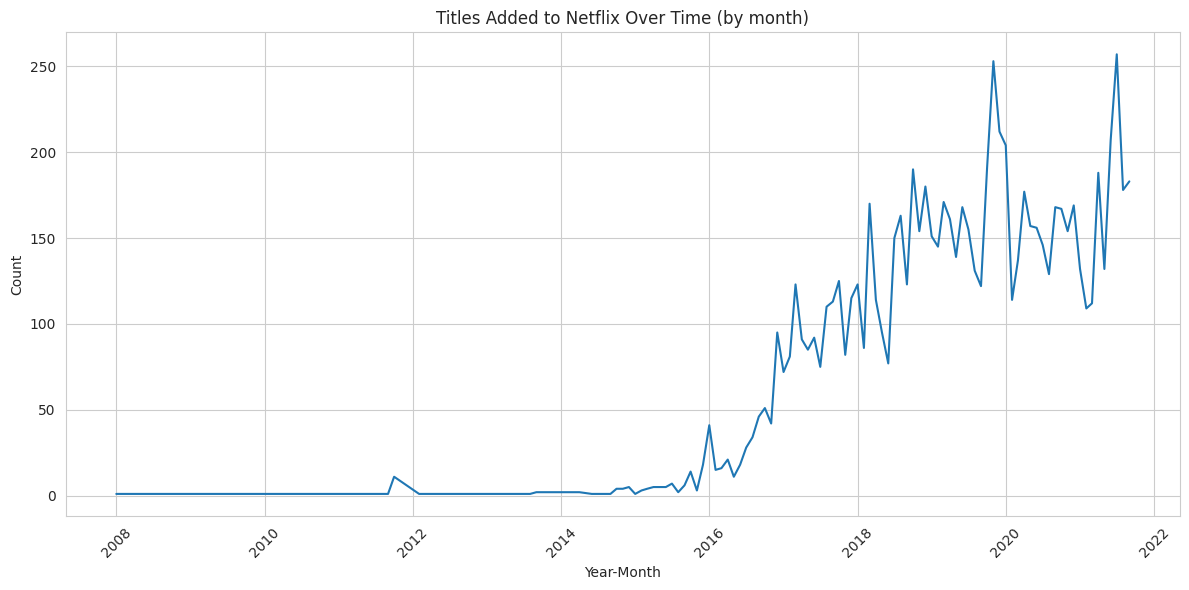

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_time = df.dropna(subset=['date_added']).copy()
df_time['year_month'] = df_time['date_added'].dt.to_period('M').dt.to_timestamp()
monthly_counts = df_time.groupby('year_month').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='year_month', y='count')
plt.title('Titles Added to Netflix Over Time (by month)')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

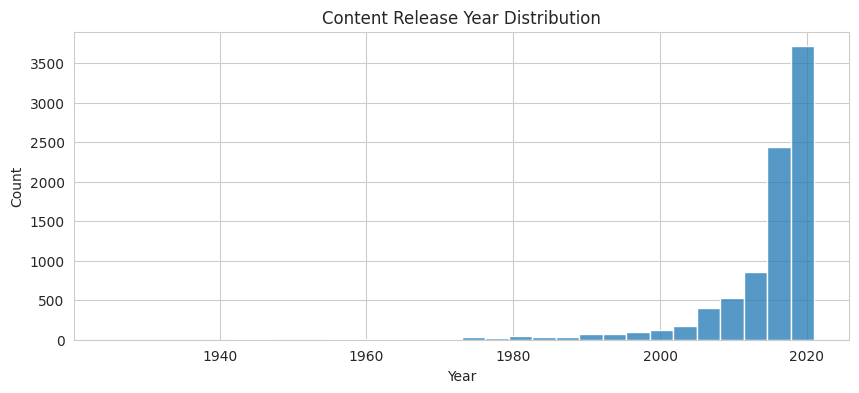

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(df_clean['release_year'], bins=30, kde=False)
plt.title("Content Release Year Distribution")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

## 8. Genre-specific trends (top 6 genres)

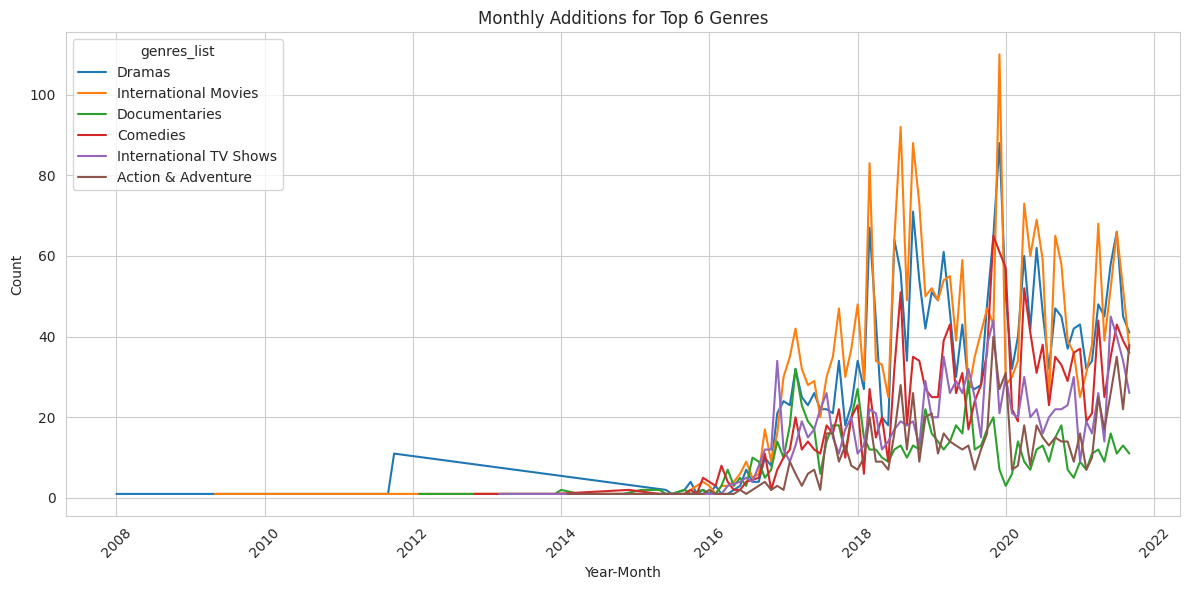

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 6
top_genres_list = top_genres.index[:top_n].tolist()
df_expl = df_time.explode('genres_list')
df_genre_time = df_expl[df_expl['genres_list'].isin(top_genres_list)]
genre_month = df_genre_time.groupby(['year_month','genres_list']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=genre_month, x='year_month', y='count', hue='genres_list')
plt.title(f'Monthly Additions for Top {top_n} Genres')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Forecasting monthly title additions (Prophet)
This fits a simple Prophet model to monthly counts and forecasts the next 12 months.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzoitmcgb/v6_kv8q8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzoitmcgb/a9jfrnk1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45823', 'data', 'file=/tmp/tmpzoitmcgb/v6_kv8q8.json', 'init=/tmp/tmpzoitmcgb/a9jfrnk1.json', 'output', 'file=/tmp/tmpzoitmcgb/prophet_modelvuaywjgd/prophet_model-20250812174700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


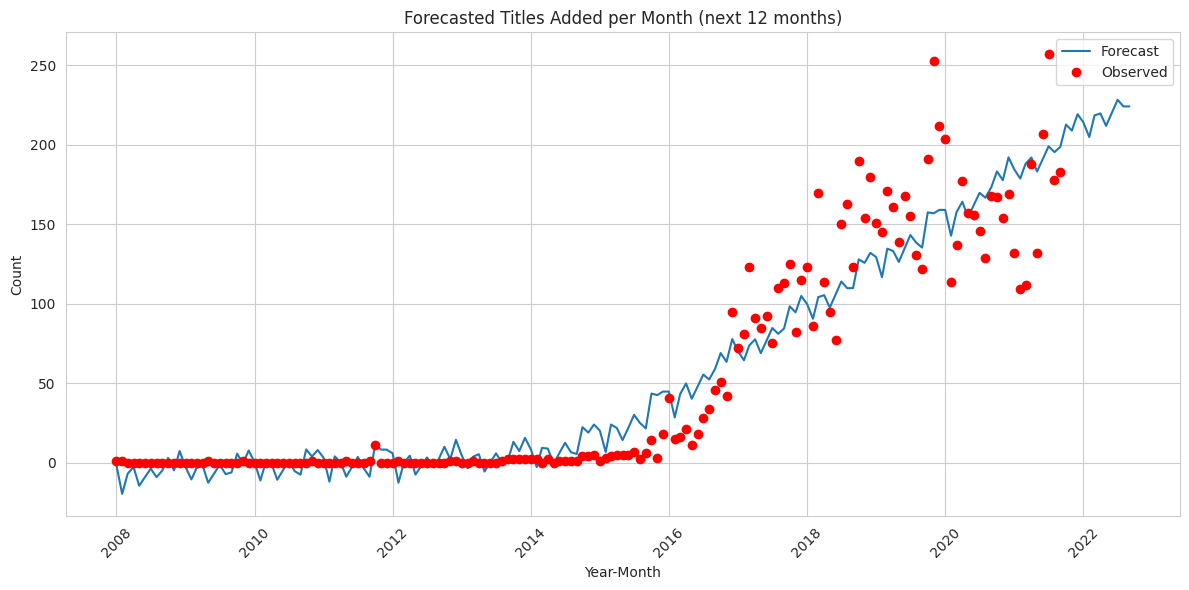

In [ ]:
ts = monthly_counts.rename(columns={'year_month':'ds','count':'y'})
ts = ts.set_index('ds').asfreq('MS', fill_value=0).reset_index()
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(ts)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)

plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.plot(ts['ds'], ts['y'], 'o', color='red', label='Observed')
plt.title('Forecasted Titles Added per Month (next 12 months)')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 10. Content embeddings (Sentence Transformers)
We embed `title + description` and compute similarity for recommendations.

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
df['text_for_embedding'] = (df['title'].fillna('') + '. ' + df['description'].fillna('')).str.slice(0,2000)
embeddings = model.encode(df['text_for_embedding'].tolist(), show_progress_bar=True, convert_to_numpy=True)
print('Embeddings shape:', embeddings.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Embeddings shape: (8807, 384)


 Rating Distribution

This chart shows how content is distributed across different rating categories, such as TV-MA, TV-14, PG, etc.

/tmp/ipython-input-1369105778.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




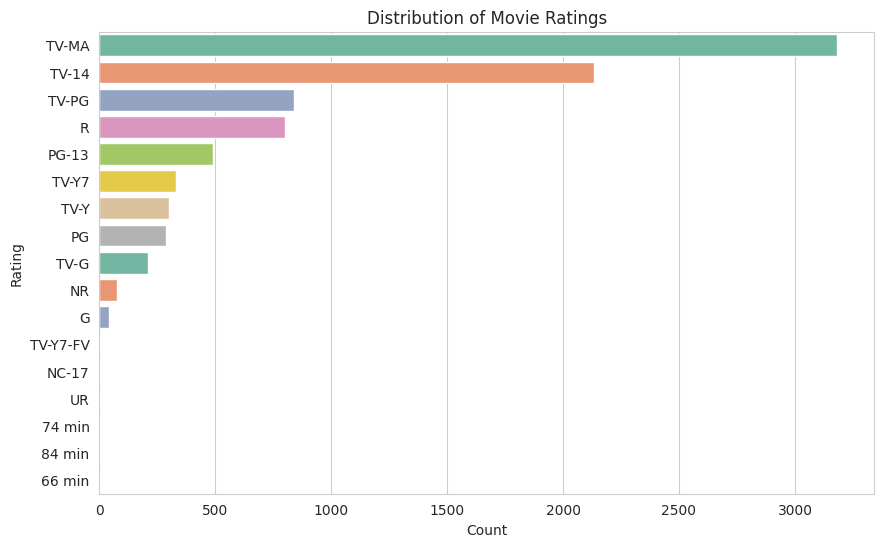

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_clean, y='rating', order=df_clean['rating'].value_counts().index, palette='Set2')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Count')
plt.ylabel('Rating')
plt.show()

## 11. Simple content-based recommender

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(embeddings)

def recommend_by_title(title, top_k=8):
    idx = df.index[df['title'].str.lower() == title.lower()]
    if len(idx) == 0:
        print('Title not found. Try exact title (case-insensitive).')
        return
    i = idx[0]
    sim_scores = list(enumerate(sim_matrix[i]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    recs = [ (df.iloc[j]['title'], float(score)) for j, score in sim_scores[1: top_k+1] ]
    return recs

sample_title = df['title'].dropna().iloc[10]
print('Sample title:', sample_title)
print('Recommendations:')
print(recommend_by_title(sample_title, top_k=6))

Sample title: Vendetta: Truth, Lies and The Mafia
Recommendations:
[('Gomorrah', 0.5621865391731262), ('Women of Mafia 2', 0.5553535223007202), ('Backfire', 0.541898250579834), ('The Ruthless', 0.5387308597564697), ('Our Godfather', 0.5032758712768555), ('Las muñecas de la mafia', 0.4838463366031647)]


## 12. UMAP projection + HDBSCAN clustering

In [8]:
# ===========================================
# 1. IMPORT LIBRARIES
# ===========================================
import pandas as pd
import numpy as np
import umap
import hdbscan
import plotly.express as px
from sentence_transformers import SentenceTransformer

# ===========================================
# 2. LOAD DATA
# ===========================================
# If you have a CSV file, uncomment the line below:
# df = pd.read_csv("your_dataset.csv")

# SAMPLE DATA (remove this when using your real dataset)
df = pd.DataFrame({
    'title': [
        'The Matrix', 'Inception', 'Finding Nemo',
        'The Godfather', 'Interstellar', 'Toy Story',
        'Pulp Fiction', 'The Dark Knight', 'Avatar',
        'Shrek', 'Coco', 'Frozen'
    ],
    'type': [
        'Movie', 'Movie', 'Animation',
        'Movie', 'Movie', 'Animation',
        'Movie', 'Movie', 'Movie',
        'Animation', 'Animation', 'Animation'
    ],
    'release_year': [
        1999, 2010, 2003,
        1972, 2014, 1995,
        1994, 2008, 2009,
        2001, 2017, 2013
    ]
})

# ===========================================
# 3. CLEAN DATA
# ===========================================
# Remove duplicates and missing titles
df = df.drop_duplicates(subset=['title'])
df = df.dropna(subset=['title'])

# ===========================================
# 4. GENERATE EMBEDDINGS
# ===========================================
print("Generating embeddings with SentenceTransformer...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['title'].tolist(), show_progress_bar=True)

# embeddings shape: (num_items, 384) for all-MiniLM-L6-v2

# ===========================================
# 5. UMAP DIMENSIONALITY REDUCTION
# ===========================================
# UMAP reduces high-dimensional vectors to 2D for visualization
reducer = umap.UMAP(
    n_neighbors=30,         # how many neighbors to consider for local structure
    metric='cosine',        # good choice for sentence embeddings
    random_state=42,        # reproducibility
    min_dist=0.1            # smaller -> more clustered points
)
umap_emb = reducer.fit_transform(embeddings)  # shape: (num_items, 2)

# ===========================================
# 6. HDBSCAN CLUSTERING
# ===========================================
# HDBSCAN automatically finds the optimal number of clusters
# min_cluster_size = smallest size grouping to be considered a cluster
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2 if len(df) < 30 else 25,  # adapt if dataset is small
    metric='euclidean',
    cluster_selection_method='eom'
)

cluster_labels = clusterer.fit_predict(umap_emb)      # cluster IDs
cluster_probs = clusterer.probabilities_              # confidence score
outlier_scores = clusterer.outlier_scores_            # outlier score (0 = in-cluster)

# ===========================================
# 7. ADD CLUSTER INFO TO DF
# ===========================================
df['umap_x'] = umap_emb[:, 0]
df['umap_y'] = umap_emb[:, 1]
df['cluster'] = cluster_labels
df['cluster_prob'] = cluster_probs
df['outlier_score'] = outlier_scores

# Print summary
print("\nCluster Summary:")
print(df['cluster'].value_counts())
print(f"Noise points (-1 label): {(df['cluster'] == -1).sum()}")

# ===========================================
# 8. VISUALIZATION
# ===========================================
fig = px.scatter(
    data_frame=df,
    x='umap_x',
    y='umap_y',
    color=df['cluster'].astype(str),    # cluster IDs as strings for legend
    size='cluster_prob',                # point size = confidence
    hover_data=['title', 'type', 'release_year', 'cluster', 'cluster_prob', 'outlier_score'],
    title='UMAP Projection of Titles (HDBSCAN Clusters)',
    opacity=0.8
)
fig.show()

# ===========================================
# 9. SAVE RESULTS
# ===========================================
df.to_csv("clustered_titles.csv", index=False)
fig.write_html("umap_hdbscan_plot.html")

print("\n✅ Clustering complete. Results saved to 'clustered_titles.csv' and 'umap_hdbscan_plot.html'.")


Generating embeddings with SentenceTransformer...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Cluster Summary:
cluster
-1    7
 0    3
 1    2
Name: count, dtype: int64
Noise points (-1 label): 7



✅ Clustering complete. Results saved to 'clustered_titles.csv' and 'umap_hdbscan_plot.html'.


## 13. Cluster summary

In [ ]:
cluster_summary = (df.explode('genres_list').groupby(['cluster','genres_list']).size().reset_index(name='count'))
top_genre_by_cluster = cluster_summary.sort_values(['cluster','count'], ascending=[True,False]).groupby('cluster').first().reset_index()
top_genre_by_cluster.head(20)

,cluster,genres_list,count
0,-1,International Movies,99
1,0,International TV Shows,31
2,1,Children & Family Movies,36
3,2,Children & Family Movies,52
4,3,International Movies,2627


Let's regenerate the embeddings.